# Recurrent Neural Network (RNN) in Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


## RNN to predict curves in 1D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from math import pi

# Generate points on a 2D line
n_points = 200
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x)

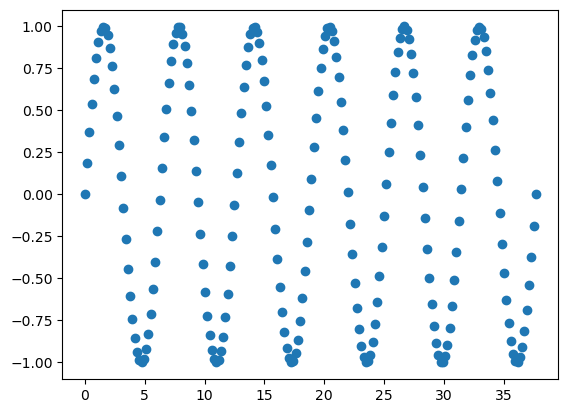

In [3]:
plt.scatter(x, y)

Split data for making numerical evaluations

In [4]:
cut_point = n_points//2
train = y[:cut_point]
test = y[cut_point:]

In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [6]:
generator[0]

(array([[0.        , 0.18831167, 0.36988529]]), array([0.53822391]))

In [7]:
generator[1]

(array([[0.18831167, 0.36988529, 0.53822391]]), array([0.68730414]))

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN

In [9]:
# define model
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(generator,epochs=10, verbose=False)

Epoch 1/10
97/97 [==============================] - 2s 3ms/step - loss: 0.1294
Epoch 2/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 3/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 4/10
97/97 [==============================] - 0s 3ms/step - loss: 3.7962e-04
Epoch 5/10
97/97 [==============================] - 0s 3ms/step - loss: 1.5452e-04
Epoch 6/10
97/97 [==============================] - 0s 3ms/step - loss: 6.5829e-05
Epoch 7/10
97/97 [==============================] - 0s 3ms/step - loss: 4.0183e-04
Epoch 8/10
97/97 [==============================] - 0s 3ms/step - loss: 6.5159e-04
Epoch 9/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 10/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0028


In [12]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=False)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred[0]) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

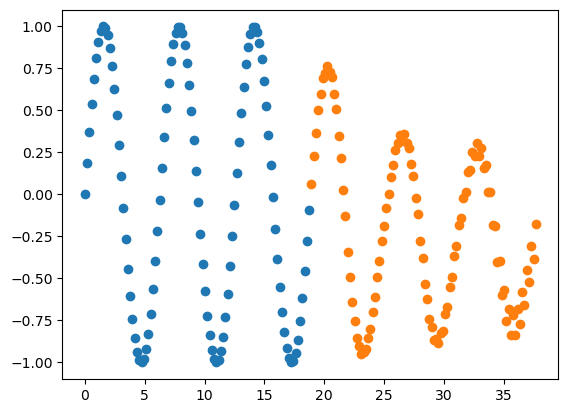

In [13]:
plt.scatter(x[:cut_point], train)
plt.scatter(x[cut_point:], np.array(test_predictions))

Lets create a function to play in a simpler way with the configurations

In [54]:
def process_and_show_rnn(x, y, cut_point, n_input, neurons=100, epochs=10, show_loss=False):
    train = y[:cut_point]
    test = y[cut_point:]

    from keras.preprocessing.sequence import TimeseriesGenerator
    n_features = 1
    generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
    generator_test = TimeseriesGenerator(test, test, length=n_input, batch_size=1)

    # define model
    model = Sequential()
    model.add(SimpleRNN(neurons, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(generator,epochs=epochs, verbose=False, 
                    validation_data=generator_test)
    
    if show_loss:
        fig, ax = plt.subplots(figsize=(5, 3))
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax.plot(train_loss, label='Training Loss')
        ax.plot(val_loss, label='Testing Loss')
        ax.legend()
    
    test_predictions = []

    first_eval_batch = train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch, verbose=False)[0]

        # append the prediction into the array
        test_predictions.append(current_pred[0]) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x, y)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x[:cut_point], train)
    ax.scatter(x[cut_point:], np.array(test_predictions))
    plt.show()

Lets try more epochs

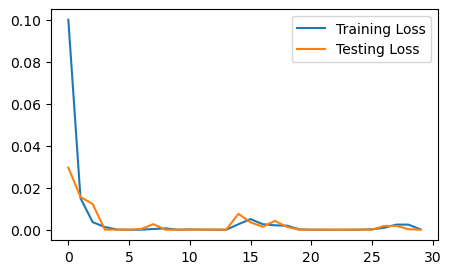

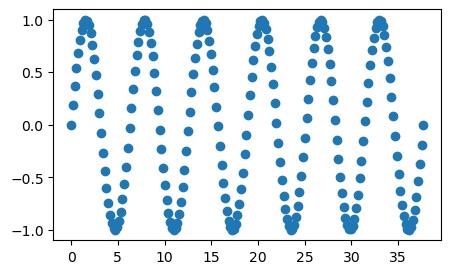

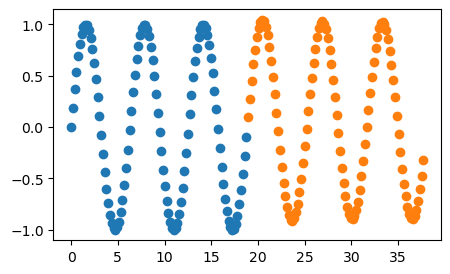

In [38]:
n_points = 200
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x)
cut_point = n_points//2
process_and_show_rnn(x, y, cut_point, n_input, neurons=100, epochs=30)

## Adding some noise

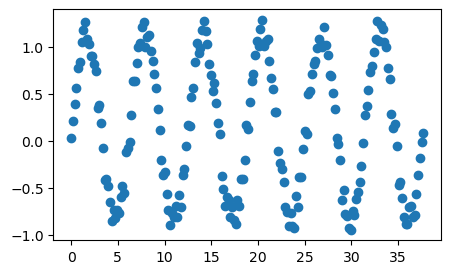

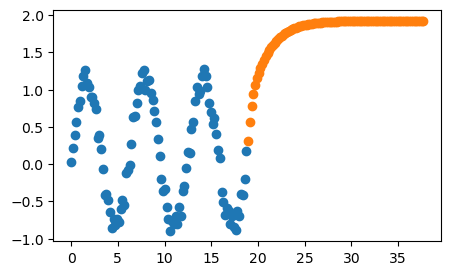

In [45]:
n_points = 200
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x) + np.random.rand(n_points) * 0.3
cut_point = n_points//2
process_and_show_rnn(x, y, cut_point, n_input=3, neurons=100, epochs=30)

Candidate solution: Use a wider window

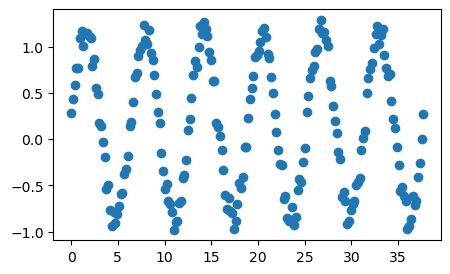

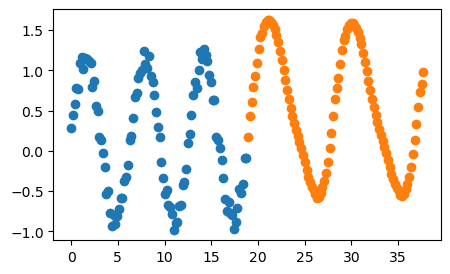

In [47]:
n_points = 200
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x) + np.random.rand(n_points) * 0.3
cut_point = n_points//2
process_and_show_rnn(x, y, cut_point, n_input=7, neurons=100, epochs=30)

Lets increment that a little more

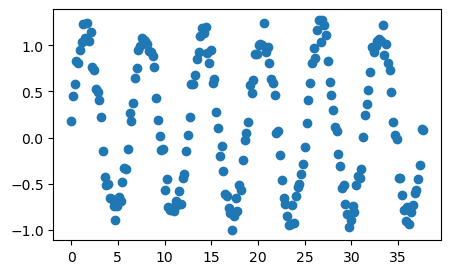

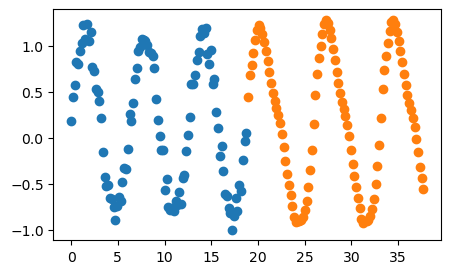

In [48]:
n_points = 200
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x) + np.random.rand(n_points) * 0.3
cut_point = n_points//2
process_and_show_rnn(x, y, cut_point, n_input=10, neurons=100, epochs=30)

## Other surfaces

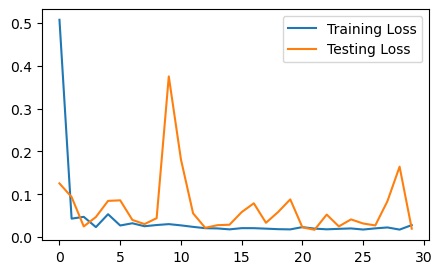

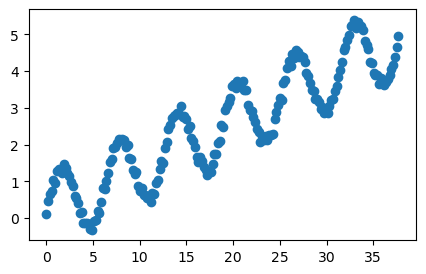

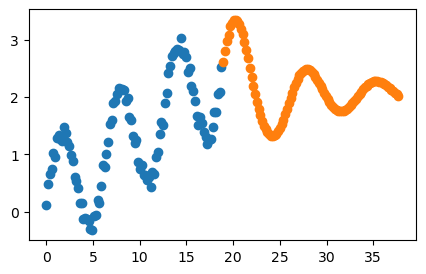

In [52]:
n_points = 200
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x) + x/8 + np.random.rand(n_points) * 0.3
cut_point = n_points//2
process_and_show_rnn(x, y, cut_point, n_input=10, neurons=100, epochs=30, show_loss=True)

Lets use more points for training and a wider window

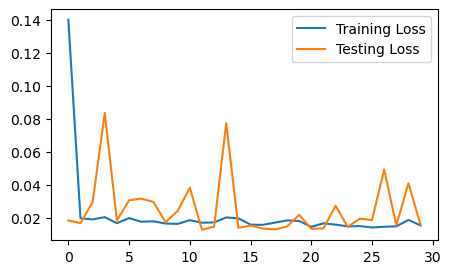

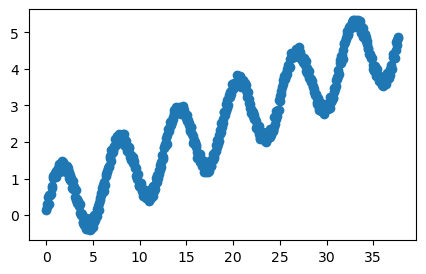

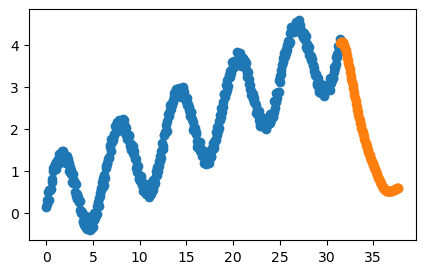

In [61]:
n_points = 600
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x) + x/8 + np.random.rand(n_points) * 0.3
cut_point = 500
process_and_show_rnn(x, y, cut_point, n_input=20, neurons=100, epochs=30, show_loss=True)

The model is not able to try no matter how hard do we play with parameters ... lets try something different ...

In [57]:
from keras.layers import LSTM

def process_and_show_lstm(x, y, cut_point, n_input, neurons=100, epochs=10, show_loss=False):
    train = y[:cut_point]
    test = y[cut_point:]

    from keras.preprocessing.sequence import TimeseriesGenerator
    n_features = 1
    generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
    generator_test = TimeseriesGenerator(test, test, length=n_input, batch_size=1)

    # define model
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(generator,epochs=epochs, verbose=False, 
                    validation_data=generator_test)
    
    if show_loss:
        fig, ax = plt.subplots(figsize=(5, 3))
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax.plot(train_loss, label='Training Loss')
        ax.plot(val_loss, label='Testing Loss')
        ax.legend()
    
    test_predictions = []

    first_eval_batch = train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch, verbose=False)[0]

        # append the prediction into the array
        test_predictions.append(current_pred[0]) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x, y)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x[:cut_point], train)
    ax.scatter(x[cut_point:], np.array(test_predictions))
    plt.show()

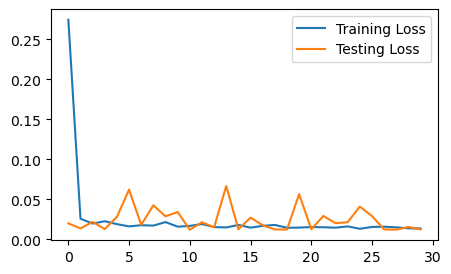

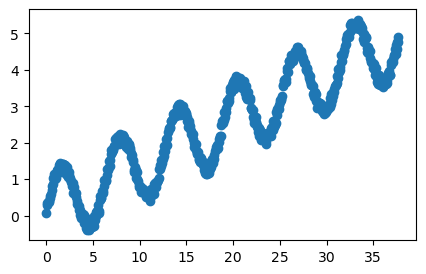

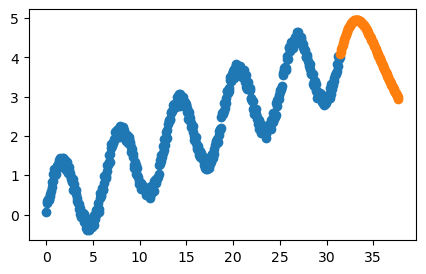

In [63]:
n_points = 600
x = np.linspace(0, 12*pi, n_points)
y = np.sin(x) + x/8 + np.random.rand(n_points) * 0.3
cut_point = 500
process_and_show_lstm(x, y, cut_point, n_input=20, neurons=100, epochs=30, show_loss=True)